# Baseline 

To evaluate the performance of our predictor, we compare it to ERGO, ImRex, and TITAN.

In [1]:
import warnings
import pandas as pd
import numpy as np
from itertools import product
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
import sys
sys.path.append('../activation-prediction/')

In [3]:
from preprocessing import add_activation_thresholds, full_aa_features, get_aa_features 
from preprocessing import get_complete_dataset

## ERGO2

### Data Preparation

Creates a csv file with columns [CDR3, epitope]. All combinations between the TCRs of the educated repertoire and the mutations are used.

In [4]:
data = get_complete_dataset()
data = add_activation_thresholds(data)
print(len(data))
data = data[data['normalization']=='AS']
data = data[data['threshold']=='46.9']
#data = data[data['is_educated']==True]
print(len(data))

30753
4131


In [5]:
data_ergo = data[['cdr3b', 'cdr3a', 'epitope', 'tcr', 'is_educated']]
data_ergo = data_ergo.rename(columns={'cdr3b': 'TRB', 'cdr3a': 'TRA', 'epitope': 'Peptide'})
for col in ['TRAV', 'TRAJ', 'TRBV', 'TRBJ', 'T-Cell-Type', 'MHC']:
    data_ergo[col] = ''
data_ergo.to_csv('results/baseline_all_pairs.csv')
data_ergo.head()

,TRB,TRA,Peptide,tcr,is_educated,TRAV,TRAJ,TRBV,TRBJ,T-Cell-Type,MHC
4743,CASSRRLGASQNTLYF,CALGSYNQGKLIF,AIINFEKL,ED5,True,,,,,,
4744,CASSRRLGASQNTLYF,CALGSYNQGKLIF,CIINFEKL,ED5,True,,,,,,
4745,CASSRRLGASQNTLYF,CALGSYNQGKLIF,DIINFEKL,ED5,True,,,,,,
4746,CASSRRLGASQNTLYF,CALGSYNQGKLIF,EIINFEKL,ED5,True,,,,,,
4747,CASSRRLGASQNTLYF,CALGSYNQGKLIF,FIINFEKL,ED5,True,,,,,,


### Prediction

Prediction was performed as described in https://github.com/IdoSpringer/ERGO-II using the github version and downloaded models.

### Evaluation

In [6]:
databases = ['vdjdb', 'mcpas']

In [7]:
def ergo_eval(database_name):
    path_res = f'results/ergo2_{database_name}.csv'
    prediction_ergo = pd.read_csv(path_res, index_col=0)

    aucs = []
    spearmans = []
    mpl.rcParams.update({'font.size': 20})
    plt.figure(figsize=(12 * 1.25, 12))
    
    
    educated_colors = sns.color_palette(
        'Blues', n_colors=len(data.query('is_educated')['tcr'].unique()) + 4
    )
    educated_idx = 1
    
    naive_colors = sns.color_palette(
        'Oranges', n_colors=len(data.query('~is_educated')['tcr'].unique()) + 4
    )
    naive_idx = 1
    
    for tcr in data['tcr'].unique():
        mask_tcr = data['tcr'] == tcr
        df_test = data[mask_tcr]
        df_test_ergo = prediction_ergo[mask_tcr] 
        df_test['prediction'] = df_test_ergo['Score']

        auc_score = metrics.roc_auc_score(df_test['is_activated'], df_test['prediction'])
        aucs.append(auc_score)
        
        sp_score = df_test['activation'].corr(df_test['prediction'], method='spearman')
        spearmans.append(sp_score)
        
        fpr, tpr, _ = metrics.roc_curve(df_test['is_activated'], df_test['prediction'])
        if tcr.startswith('ED'):
            c = educated_colors[educated_idx]
            plt.plot(fpr, tpr, c=c, linewidth=3)
            educated_idx += 1
        else:
            c = naive_colors[naive_idx]
            plt.plot(fpr, tpr, c=c, linewidth=3)
            naive_idx += 1
    avg_auc = sum(aucs) / len(aucs)
    avg_sp = sum(spearmans) / len(spearmans)
    print(f'Average AUROC: {avg_auc}')
    print(f'Average Spearman Coefficient: {avg_sp}')
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)

    plt.ylabel('TPR')
    plt.xlabel('FPR')

    sns.despine()
    plt.title(f'trained on {database_name} - Average AUROC: {avg_auc:.2f}')
    plt.show()

--- trained on vdjdb---
Average AUROC: 0.5517928983238344
Average Spearman Coefficient: 0.10921891412761661


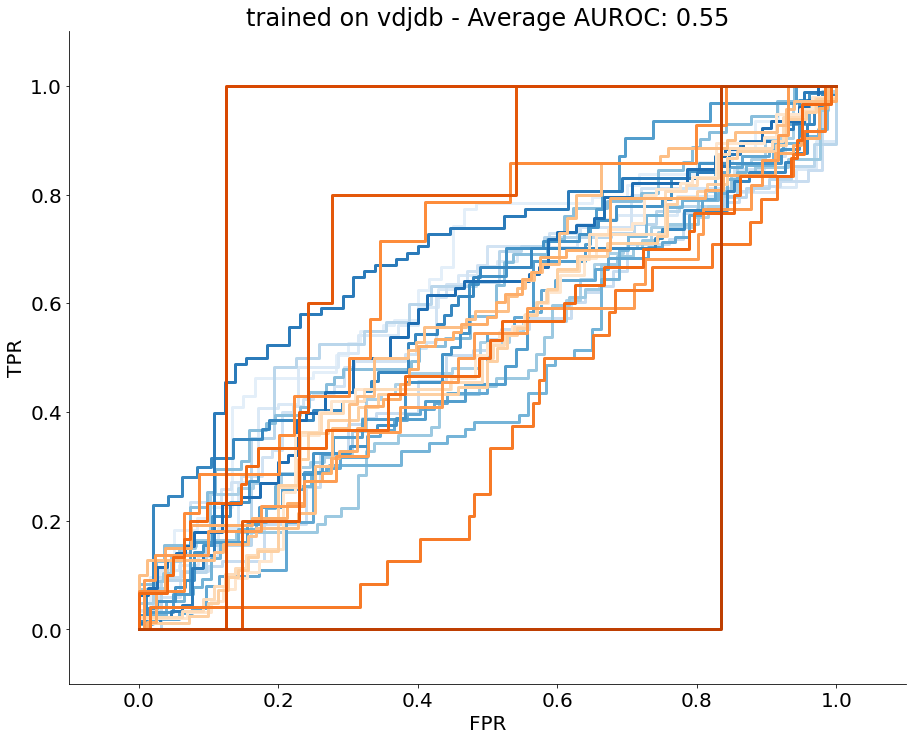

--- trained on mcpas---
Average AUROC: 0.45885505565989276
Average Spearman Coefficient: -0.08048017568009697


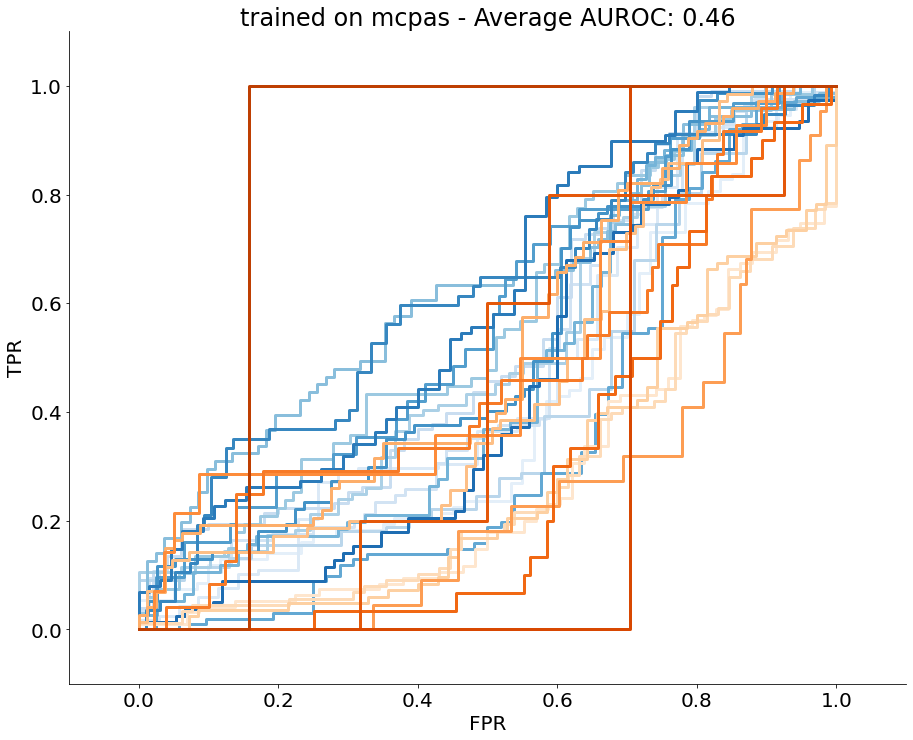

In [8]:
for db in databases:
    print(f'--- trained on {db}---')
    ergo_eval(db)


## ImRex

https://github.com/pmoris/ImRex

Average AUROC: 0.5051326960768168
Average Spearman Coefficient: 0.006369237378621998


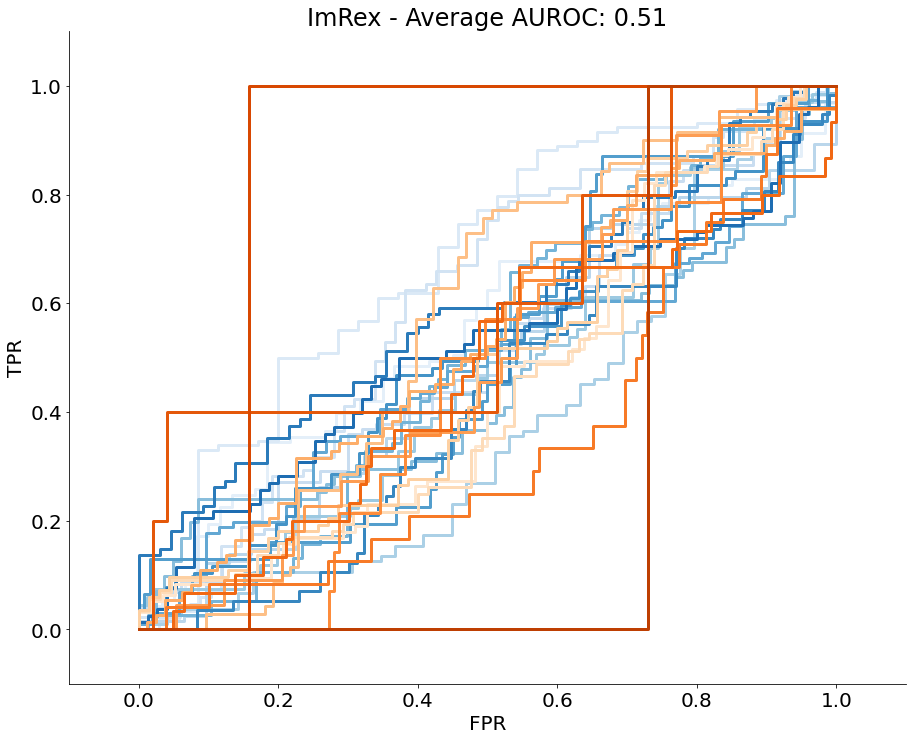

In [9]:
path_res = f'results/MG_imrex.csv'
prediction_imrex = pd.read_csv(path_res, index_col=0)

aucs = []
spearmans = []
mpl.rcParams.update({'font.size': 20})
plt.figure(figsize=(12 * 1.25, 12))


educated_colors = sns.color_palette(
    'Blues', n_colors=len(data.query('is_educated')['tcr'].unique()) + 4
)
educated_idx = 1

naive_colors = sns.color_palette(
    'Oranges', n_colors=len(data.query('~is_educated')['tcr'].unique()) + 4
)
naive_idx = 1

for tcr in data['tcr'].unique():
    mask_tcr = data['tcr'] == tcr
    df_test = data[mask_tcr]
    df_test_imrex = prediction_imrex[mask_tcr] 
    df_test['prediction'] = df_test_imrex['prediction_score']

    auc_score = metrics.roc_auc_score(df_test['is_activated'], df_test['prediction'])
    aucs.append(auc_score)

    sp_score = df_test['activation'].corr(df_test['prediction'], method='spearman')
    spearmans.append(sp_score)

    fpr, tpr, _ = metrics.roc_curve(df_test['is_activated'], df_test['prediction'])
    if tcr.startswith('ED'):
        c = educated_colors[educated_idx]
        plt.plot(fpr, tpr, c=c, linewidth=3)
        educated_idx += 1
    else:
        c = naive_colors[naive_idx]
        plt.plot(fpr, tpr, c=c, linewidth=3)
        naive_idx += 1
avg_auc = sum(aucs) / len(aucs)
avg_sp = sum(spearmans) / len(spearmans)
print(f'Average AUROC: {avg_auc}')
print(f'Average Spearman Coefficient: {avg_sp}')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)

plt.ylabel('TPR')
plt.xlabel('FPR')

sns.despine()
plt.title(f'ImRex - Average AUROC: {avg_auc:.2f}')
plt.show()

# TITAN

https://github.com/PaccMann/TITAN

## Data Preparation
The data needs to be in the following format:
- tcrs (csv): sequence, id
- epitopes (csv): sequence, id
- test_tcrs (csv): id_tcr, id_epitope, label (label dummy value)

Both csv files without header + tab separated.

In [10]:
data_epitope = data[['epitope']]
data_epitope['id'] = data_epitope.index.values
data_epitope.to_csv('results/input_titan_epitopes.csv', sep='\t', index=False, header=False)

In [11]:
data_tcr = data[['cdr3b']]
data_tcr['id'] = data_tcr.index.values
data_tcr.to_csv('results/input_titan_tcrs.csv', sep='\t', index=False, header=False)

In [12]:
data_test = data_tcr[['id']]
data_test['ligand_name'] = data_epitope['id'].values
data_test['sequence_id'] = data_tcr['id'].values
data_test['label'] = data.apply(lambda row: 1 if row['is_activated'] else 0, axis=1)
data_test = data_test[['ligand_name', 'sequence_id', 'label']]
data_test.to_csv('results/input_titan_test_ids.csv')

- Install TITAN from github (see above) including the pretrained model referenced on github
- Use their pytoda module to convert the input_titan_epitopes.csv to smi
- Change the batch size in model_params.json to a true divider of 4131 since otherwise the last batch is not handled correctly
- Run following comand with adapted paths depending on your installation

python scripts/flexible_model_eval.py ../../data/input_titan_test_ids.csv ../../data/input_titan_tcrs.csv ../../data/input_titan_epitopes.smi trained_model bimodal_mca output_titan_prediction

## AUC curves

Average AUROC: 0.4931725156556928
Average Spearman Coefficient: -0.04958572083618483


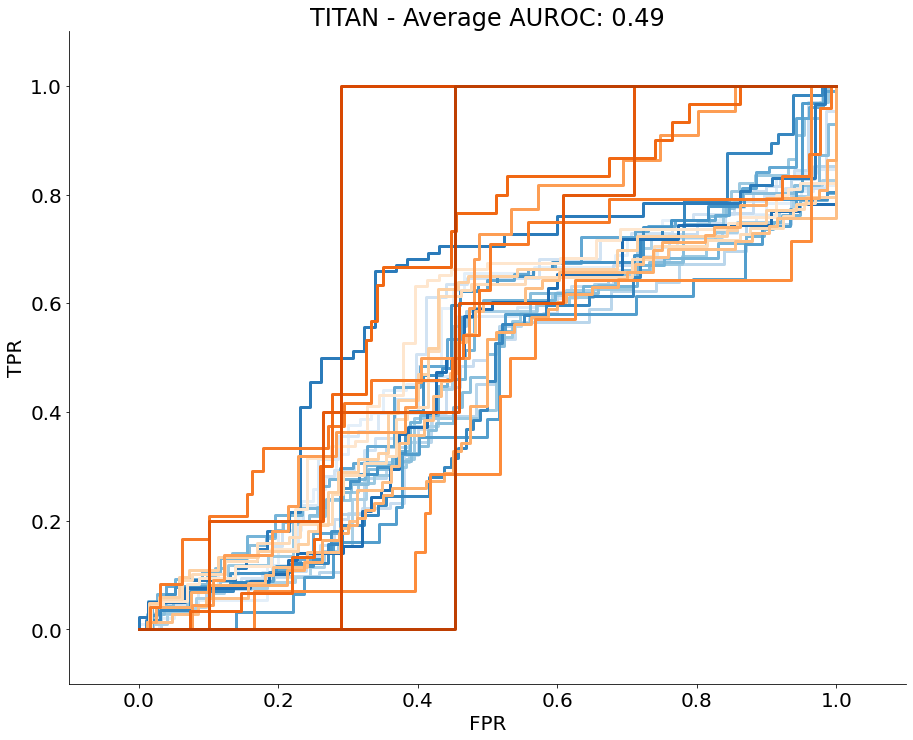

In [13]:
path_titan_res = f'results/output_titan_prediction.npy'
prediction_titan = np.load(path_titan_res)[0]

aucs = []
spearmans = []
mpl.rcParams.update({'font.size': 20})
plt.figure(figsize=(12 * 1.25, 12))


educated_colors = sns.color_palette(
    'Blues', n_colors=len(data.query('is_educated')['tcr'].unique()) + 4
)
educated_idx = 1

naive_colors = sns.color_palette(
    'Oranges', n_colors=len(data.query('~is_educated')['tcr'].unique()) + 4
)
naive_idx = 1

for tcr in data['tcr'].unique():
    mask_tcr = data['tcr'] == tcr
    df_test = data[mask_tcr]
    df_test['prediction'] = prediction_titan[mask_tcr] 

    auc_score = metrics.roc_auc_score(df_test['is_activated'], df_test['prediction'])
    aucs.append(auc_score)

    sp_score = df_test['activation'].corr(df_test['prediction'], method='spearman')
    spearmans.append(sp_score)

    fpr, tpr, _ = metrics.roc_curve(df_test['is_activated'], df_test['prediction'])
    if tcr.startswith('ED'):
        c = educated_colors[educated_idx]
        plt.plot(fpr, tpr, c=c, linewidth=3)
        educated_idx += 1
    else:
        c = naive_colors[naive_idx]
        plt.plot(fpr, tpr, c=c, linewidth=3)
        naive_idx += 1
avg_auc = sum(aucs) / len(aucs)
avg_sp = sum(spearmans) / len(spearmans)
print(f'Average AUROC: {avg_auc}')
print(f'Average Spearman Coefficient: {avg_sp}')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)

plt.ylabel('TPR')
plt.xlabel('FPR')

sns.despine()
plt.title(f'TITAN - Average AUROC: {avg_auc:.2f}')
plt.show()

# Comparision of the Results

Our Setting: cross-TCR

In [14]:
path_res = f'results/ergo2_vdjdb.csv'
prediction_ergo = pd.read_csv(path_res, index_col=0)
prediction_ergo = prediction_ergo[prediction_ergo['Peptide']!='SIINFEKL']
prediction_ergo

,TRB,TRA,Peptide,tcr,is_educated,TRAV,TRAJ,TRBV,TRBJ,T-Cell-Type,MHC,Score
Unnamed: 0,,,,,,,,,,,,
4743,CASSRRLGASQNTLYF,CALGSYNQGKLIF,AIINFEKL,ED5,True,NaN,NaN,NaN,NaN,NaN,NaN,0.140434
4744,CASSRRLGASQNTLYF,CALGSYNQGKLIF,CIINFEKL,ED5,True,NaN,NaN,NaN,NaN,NaN,NaN,0.042371
4745,CASSRRLGASQNTLYF,CALGSYNQGKLIF,DIINFEKL,ED5,True,NaN,NaN,NaN,NaN,NaN,NaN,0.054274
4746,CASSRRLGASQNTLYF,CALGSYNQGKLIF,EIINFEKL,ED5,True,NaN,NaN,NaN,NaN,NaN,NaN,0.057856
4747,CASSRRLGASQNTLYF,CALGSYNQGKLIF,FIINFEKL,ED5,True,NaN,NaN,NaN,NaN,NaN,NaN,0.065884
...,...,...,...,...,...,...,...,...,...,...,...,...
8868,CASGDRERDTQYF,CAVSNYGSSGNKLIF,SIINFEKS,H5,False,NaN,NaN,NaN,NaN,NaN,NaN,0.068826
8869,CASGDRERDTQYF,CAVSNYGSSGNKLIF,SIINFEKT,H5,False,NaN,NaN,NaN,NaN,NaN,NaN,0.043491
8870,CASGDRERDTQYF,CAVSNYGSSGNKLIF,SIINFEKV,H5,False,NaN,NaN,NaN,NaN,NaN,NaN,0.214850


In [15]:
path_imrex = f'results/MG_imrex.csv'
prediction_imrex = pd.read_csv(path_imrex, index_col=0)
prediction_imrex = prediction_imrex[prediction_imrex['antigen.epitope']!='SIINFEKL']
prediction_imrex

,cdr3,TRA,antigen.epitope,tcr,is_educated,TRAV,TRAJ,TRBV,TRBJ,T-Cell-Type,MHC,prediction_score
Unnamed: 0,,,,,,,,,,,,
4743,CASSRRLGASQNTLYF,CALGSYNQGKLIF,AIINFEKL,ED5,True,NaN,NaN,NaN,NaN,NaN,NaN,0.839749
4744,CASSRRLGASQNTLYF,CALGSYNQGKLIF,CIINFEKL,ED5,True,NaN,NaN,NaN,NaN,NaN,NaN,0.869724
4745,CASSRRLGASQNTLYF,CALGSYNQGKLIF,DIINFEKL,ED5,True,NaN,NaN,NaN,NaN,NaN,NaN,0.743288
4746,CASSRRLGASQNTLYF,CALGSYNQGKLIF,EIINFEKL,ED5,True,NaN,NaN,NaN,NaN,NaN,NaN,0.794590
4747,CASSRRLGASQNTLYF,CALGSYNQGKLIF,FIINFEKL,ED5,True,NaN,NaN,NaN,NaN,NaN,NaN,0.845540
...,...,...,...,...,...,...,...,...,...,...,...,...
8868,CASGDRERDTQYF,CAVSNYGSSGNKLIF,SIINFEKS,H5,False,NaN,NaN,NaN,NaN,NaN,NaN,0.494102
8869,CASGDRERDTQYF,CAVSNYGSSGNKLIF,SIINFEKT,H5,False,NaN,NaN,NaN,NaN,NaN,NaN,0.522712
8870,CASGDRERDTQYF,CAVSNYGSSGNKLIF,SIINFEKV,H5,False,NaN,NaN,NaN,NaN,NaN,NaN,0.665467


In [16]:
path_res = f'results/output_titan_prediction.npy'
prediction_titan = pd.read_csv(f'results/ergo2_vdjdb.csv', index_col=0)  # read ergo for the remaining information
prediction_titan['Score'] = np.load(path_res)[0]
prediction_titan = prediction_titan[prediction_titan['Peptide']!='SIINFEKL']
prediction_titan

,TRB,TRA,Peptide,tcr,is_educated,TRAV,TRAJ,TRBV,TRBJ,T-Cell-Type,MHC,Score
Unnamed: 0,,,,,,,,,,,,
4743,CASSRRLGASQNTLYF,CALGSYNQGKLIF,AIINFEKL,ED5,True,NaN,NaN,NaN,NaN,NaN,NaN,0.011655
4744,CASSRRLGASQNTLYF,CALGSYNQGKLIF,CIINFEKL,ED5,True,NaN,NaN,NaN,NaN,NaN,NaN,0.011424
4745,CASSRRLGASQNTLYF,CALGSYNQGKLIF,DIINFEKL,ED5,True,NaN,NaN,NaN,NaN,NaN,NaN,0.017637
4746,CASSRRLGASQNTLYF,CALGSYNQGKLIF,EIINFEKL,ED5,True,NaN,NaN,NaN,NaN,NaN,NaN,0.016515
4747,CASSRRLGASQNTLYF,CALGSYNQGKLIF,FIINFEKL,ED5,True,NaN,NaN,NaN,NaN,NaN,NaN,0.062495
...,...,...,...,...,...,...,...,...,...,...,...,...
8868,CASGDRERDTQYF,CAVSNYGSSGNKLIF,SIINFEKS,H5,False,NaN,NaN,NaN,NaN,NaN,NaN,0.043662
8869,CASGDRERDTQYF,CAVSNYGSSGNKLIF,SIINFEKT,H5,False,NaN,NaN,NaN,NaN,NaN,NaN,0.038307
8870,CASGDRERDTQYF,CAVSNYGSSGNKLIF,SIINFEKV,H5,False,NaN,NaN,NaN,NaN,NaN,NaN,0.027647


In [17]:
path_our = 'results/tcr_stratified_classification_performance.csv.gz'
prediction_ours = pd.read_csv(path_our, compression='gzip')
prediction_ours = prediction_ours[prediction_ours['normalization']=='AS']
prediction_ours = prediction_ours[prediction_ours['threshold']==46.9]
prediction_ours = prediction_ours[prediction_ours['tcr'].isin(prediction_ergo['tcr'].unique())]
prediction_ours

,normalization,threshold,tcr,mut_pos,mut_ami,wild_activation,activation,is_activated,pred
4712,AS,46.9,ED5,0,A,79.73,25.659542,False,0.258
4713,AS,46.9,ED5,0,C,79.73,12.799865,False,0.091
4714,AS,46.9,ED5,0,D,79.73,50.122836,True,0.404
4715,AS,46.9,ED5,0,E,79.73,78.234689,True,0.151
4716,AS,46.9,ED5,0,F,79.73,5.508727,False,0.124
...,...,...,...,...,...,...,...,...,...
8811,AS,46.9,H5,7,S,6.06,2.813571,False,0.691
8812,AS,46.9,H5,7,T,6.06,4.359490,False,0.608
8813,AS,46.9,H5,7,V,6.06,3.215510,False,0.599
8814,AS,46.9,H5,7,W,6.06,1.545918,False,0.587


In [18]:
prediction_ergo['tcr'].unique()

array(['ED5', 'ED8', 'ED9', 'ED10', 'ED21', 'ED23', 'ED28', 'ED40',
       'ED46', 'ED45', 'ED39', 'ED33', 'ED31', 'ED16_1', 'ED16_30',
       'OTI_PH', 'LR_OTI_1', 'LR_OTI_2', 'B11', 'B15', 'B3', 'F4', 'E8',
       'B13', 'G6', 'F5', 'H5'], dtype=object)

In [19]:
def get_auc_per_tcr(data, tcr, y_true, col_pred):
    data_tmp = data[data['tcr']==tcr]
    y_pred = data_tmp[col_pred]
    auc_score = metrics.roc_auc_score(y_true, y_pred)
    return auc_score    

In [20]:
performance = []

for tcr in prediction_ergo['tcr'].unique():
    y_true = prediction_ours[prediction_ours['tcr']==tcr]['is_activated']
    auc_ergo = get_auc_per_tcr(prediction_ergo, tcr, y_true, col_pred='Score')
    auc_imrex = get_auc_per_tcr(prediction_imrex, tcr, y_true, col_pred='prediction_score')
    auc_titan = get_auc_per_tcr(prediction_titan, tcr, y_true, col_pred='Score')
    auc_ours = get_auc_per_tcr(prediction_ours, tcr, y_true, col_pred='pred')
    performance.append([tcr, auc_ergo, auc_imrex, auc_titan, auc_ours])
performance = pd.DataFrame(performance, columns=['tcr', 'ergo', 'imrex', 'titan', 'ours'])
performance = performance[~performance['tcr'].isin(['LR_OTI_1', 'LR_OTI_2'])]
performance = performance.set_index('tcr')
order = list(performance.index)
order.remove('OTI_PH')
order = ['OTI_PH'] + order
performance = performance.reindex(order)
performance

,ergo,imrex,titan,ours
tcr,,,,
OTI_PH,0.526963,0.455613,0.516324,0.958731
ED5,0.648370,0.547101,0.495290,0.810236
ED8,0.585348,0.679609,0.474481,0.962027
ED9,0.591912,0.605392,0.503676,0.908876
ED10,0.490392,0.506275,0.449804,0.883922
ED21,0.582245,0.482538,0.417755,0.931352
ED23,0.526253,0.381018,0.445215,0.933129
ED28,0.478682,0.477273,0.453841,0.862491
ED40,0.615505,0.454181,0.458885,0.877700


In [21]:
len(data.query('~is_educated')['tcr'].unique())

11

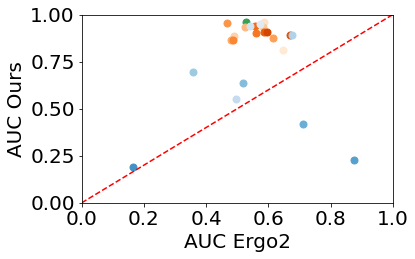

In [22]:
educated_colors = sns.color_palette(
    'Oranges', n_colors=len(data.query('is_educated')['tcr'].unique()) + 4
)
educated_idx = 1

naive_colors = sns.color_palette(
    'Blues', n_colors=len(data.query('~is_educated')['tcr'].unique()) + 4
)
naive_idx = 1

ot1_colors = sns.color_palette(
    'Greens', n_colors=2
)
ot1_idx = 1

for row in performance.iterrows():
    if row[0] == 'OTI_PH':
        c = ot1_colors[ot1_idx]
        ot1_idx += 1
    elif row[0].startswith('ED'):
        c = educated_colors[educated_idx]
        educated_idx += 1
    else:
        c = naive_colors[naive_idx]
        naive_idx += 1
    plt.plot(row[1]['ergo'], row[1]['ours'], c=c, marker='o', markersize=7)

plt.xlabel('AUC Ergo2')
plt.ylabel('AUC Ours')
plt.ylim(0, 1)
plt.xlim(0, 1)

plt.plot((0, 1), (0, 1), 'r--')

#plt.show()
plt.tight_layout()

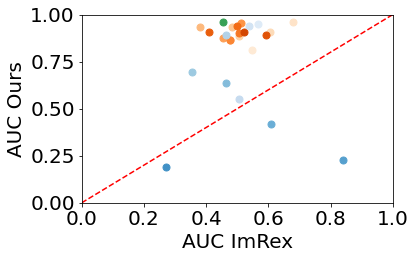

In [23]:
educated_colors = sns.color_palette(
    'Oranges', n_colors=len(data.query('is_educated')['tcr'].unique()) + 4
)
educated_idx = 1

naive_colors = sns.color_palette(
    'Blues', n_colors=len(data.query('~is_educated')['tcr'].unique()) + 4
)
naive_idx = 1

ot1_colors = sns.color_palette(
    'Greens', n_colors=2
)
ot1_idx = 1

for row in performance.iterrows():
    if row[0] == 'OTI_PH':
        c = ot1_colors[ot1_idx]
        ot1_idx += 1
    elif row[0].startswith('ED'):
        c = educated_colors[educated_idx]
        educated_idx += 1
    else:
        c = naive_colors[naive_idx]
        naive_idx += 1
    plt.plot(row[1]['imrex'], row[1]['ours'], c=c, marker='o', markersize=7)

plt.xlabel('AUC ImRex')
plt.ylabel('AUC Ours')
plt.ylim(0, 1)
plt.xlim(0, 1)

plt.plot((0, 1), (0, 1), 'r--')

#plt.show()
plt.tight_layout()

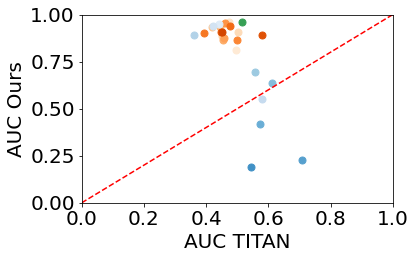

In [24]:
educated_colors = sns.color_palette(
    'Oranges', n_colors=len(data.query('is_educated')['tcr'].unique()) + 4
)
educated_idx = 1

naive_colors = sns.color_palette(
    'Blues', n_colors=len(data.query('~is_educated')['tcr'].unique()) + 4
)
naive_idx = 1

ot1_colors = sns.color_palette(
    'Greens', n_colors=2
)
ot1_idx = 1

for row in performance.iterrows():
    if row[0] == 'OTI_PH':
        c = ot1_colors[ot1_idx]
        ot1_idx += 1
    elif row[0].startswith('ED'):
        c = educated_colors[educated_idx]
        educated_idx += 1
    else:
        c = naive_colors[naive_idx]
        naive_idx += 1
    plt.plot(row[1]['titan'], row[1]['ours'], c=c, marker='o', markersize=7)

plt.xlabel('AUC TITAN')
plt.ylabel('AUC Ours')
plt.ylim(0, 1)
plt.xlim(0, 1)

plt.plot((0, 1), (0, 1), 'r--')

#plt.show()
plt.tight_layout()

In [25]:
def set_font_size(font_size):
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size, title_fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)   # fontsize of the figure title

In [26]:
sns.set(context='paper', style='whitegrid')
plt.rc('grid', linewidth=0.3)
sns.set_palette('colorblind')
set_font_size(10)

In [27]:
performance.mean()

ergo     0.555266
imrex    0.508514
titan    0.493040
ours     0.799553
dtype: float64

In [28]:
color_dict = {}

educated_idx = 1
naive_idx = 1
for tcr in performance.index:
    if tcr.startswith('ED'):
        educated_idx += 1
        c = educated_colors[educated_idx]
    elif tcr == 'OTI_PH':
        c = 'C2'
    else:
        naive_idx += 1
        c = naive_colors[naive_idx]
    color_dict[tcr] = c

In [29]:
performance_cat = performance
performance_cat['tcr'] = performance.index
performance_cat = performance_cat.melt(['tcr'], value_name='AUC', var_name='Model')
performance_cat['color'] = [color_dict[tcr] for tcr in performance_cat['tcr']]
performance_cat

,tcr,Model,AUC,color
0,OTI_PH,ergo,0.526963,C2
1,ED5,ergo,0.648370,"(0.9955709342560554, 0.8907958477508651, 0.785..."
2,ED8,ergo,0.585348,"(0.9940945790080739, 0.8583160322952711, 0.720..."
3,ED9,ergo,0.591912,"(0.9926182237600923, 0.825836216839677, 0.6555..."
4,ED10,ergo,0.490392,"(0.9921568627450981, 0.7769934640522875, 0.572..."
...,...,...,...,...
95,E8,ours,0.696289,"(0.5168627450980392, 0.7357477893118032, 0.860..."
96,B13,ours,0.637978,"(0.41708573625528644, 0.6806305267204922, 0.83..."
97,G6,ours,0.419728,"(0.3363783160322953, 0.6255132641291811, 0.806..."
98,F5,ours,0.225166,"(0.25628604382929643, 0.5700115340253749, 0.77..."


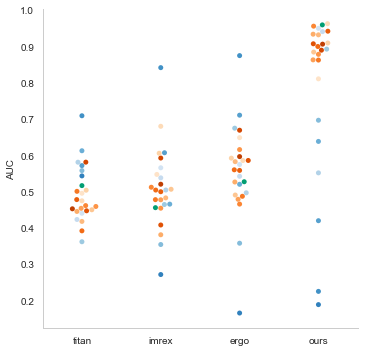

In [30]:
plot_cat = sns.catplot(data=performance_cat, x='Model', y='AUC', hue='tcr', order=['titan', 'imrex', 'ergo', 'ours'],
                      palette=performance_cat['color'],
                      kind='swarm')
plot_cat.set(ylabel='AUC')

plot_cat._legend.remove()
plot_cat.set(xlabel=None)
plt.grid(False)
sns.despine()